In [27]:
from ipyparallel import Client

rc = Client()

dview = rc[:]
lbview = rc.load_balanced_view()

print("Connected to %d workers: %s" % (len(rc.ids), rc.ids))

Connected to 16 workers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18]


In [24]:
#%%px --local
from scipy.special import legendre
import numpy as np
from numpy.polynomial.legendre import Legendre
import numpy.polynomial.polynomial as poly
from numpy.random import normal, uniform, seed
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error
%matplotlib notebook

### Criando polinômios de Legendre:
1. Sorteia-se a partir de uma distribuição normal os coeficientes do polinômio.
+ Cria-se o polinômio f = a0 * L0 + a1 * L1 + ... + aq * Lq.
+ Calcula-se o valor esperado de f² (E[f²]). 
+ Reescala-se os coeficientes para que o E[f²] = 1. a0_rescaled = a0/sqrt(E[f²])

In [2]:
#%%px --local
def create_legendre(q):
    """ Create scaled legendre polynomial of order q """
    # Create q+1 coefficients
    coeffs = normal(size=q+1) 
    # Create Qth order Legendre polynomial combination
    leg_pol = Legendre(coeffs)
    
    # Get expected value of Legendre polynomial in a uniform distribution varying from -1 to 1
    # exp_val = stats.uniform.expect(lambda x: (leg_pol ** 2)(x), loc=-1, scale=2)
    # x = np.linspace(-1,1,10000)
    # exp_val = (leg_pol ** 2)(x).mean()
    exp_val = 0
    for i in range(0,len(coeffs),2):
        coeff_temp = [0]*len(coeffs)
        coeff_temp[i] = coeffs[i]
        try:
            coeff_temp[i+1] = coeffs[i+1]
        except IndexError:
            pass
        # Create Qth order Legendre polynomial combination
        leg_pol_temp = Legendre(coeff_temp)
        leg_integ = leg_pol_temp.integ()
        coeffs_sum = np.insert(coeff_temp, 0, 0)
        exp_val += np.multiply(coeffs_sum, leg_integ.coef).sum()
    
    # Rescale coefficients and recreate Legendre
    rescaled_coeffs = coeffs/np.sqrt(exp_val)
    rescaled_leg = Legendre(rescaled_coeffs)
    
    ####### EXTRA #######
    # Check if E[f²] = 1
    #print(stats.uniform.expect(lambda x: (rescaled_leg ** 2)(x), loc=-1, scale=2))
    #####################

    return rescaled_leg

### Calculando Eout
Dado um polinômio de Legendre de ordem q f(x), N pontos e a ordem h do polinômio da solução
1. Estima-se uma solução de ordem h para o polinômio hq
+ Calcula-se o Eout com o valor esperado: E[(hq(x) - f(x) - sigma*epsilon)²]

In [38]:
#%%px --local
def get_eout(f, h, x_in):
    y = f(x_in) # + RUIDO
    #hq = np.polyfit(x_in, y, h)
    hq = poly.polyfit(x_in, y, h)
    #eout = stats.uniform.expect(lambda x: (np.polyval(hq, x)-f(x))**2, loc=-1, scale=2)
    eout = stats.uniform.expect(lambda x: (poly.polyval(x, hq)-f(x))**2, loc=-1, scale=2)
    
    ####### EXTRA #######
    # Empirical Eout
    x_out = np.linspace(-1,1,1000)
    y_out = f(x_out) # + RUIDO
    #y_hq_in = np.polyval(hq, x_in)
    y_hq_in = poly.polyval(x_in, hq)
    #y_hq_out = np.polyval(hq, x_out)
    y_hq_out = poly.polyval(x_out, hq)
    error_insample = mean_squared_error(y, y_hq_in)
    error_outofsample = mean_squared_error(y_out, y_hq_out)

    # Plot functions
    plot_y = plt.plot(x_in, y, label="Polinômio de ordem 15")
    plt.legend()
    #plt.plot(y_hq_in)
    plt.show()
    
    # Print errors
    print("Analytic %f" % eout)
    print("In Sample %f" % error_insample)
    print("Out of Sample Experimental %f" % error_outofsample)
    #####################
    
    return eout

### Paralelizando
Para cada número de pontos n:
1. Para cada complexidade q:
  1. Para cada experimento k:
    1. Cria-se um polinômio de Legendre de ordem q f(x).
    + Cria-se N pontos para serem avaliados nesse polinômio: y = f(x) + sigma*epsilon
    + Calcula-se o Eout para hipóteses de ordem 2 e 10
  + Calcula-se a média dos Eouts
  + Calcula-se a diferença entre os Eouts, essa será a medida de Overfitting

In [15]:
#%%px --local
EXPERIMENT = 1
N_MAX = 130
#Q_MAX = 100
Q_MAX = 1
N_START = 1
NAME = "data_teste_%d+%d_%d_%d" %(N_MAX, N_START, Q_MAX, EXPERIMENT)
NAME_PNG = NAME + '.png'
NAME_PKL = NAME + '.pkl'
NAME_RUN = NAME + 'times_run.pkl'
print(NAME_PKL)

data_teste_130+1_1_1.pkl


In [33]:
#%%px --local
def create_plot(q, n, k, seed_init):
    seed(seed_init)
    f = create_legendre(q+1)
    x_in = uniform(-1,1,n+1)
    x_in = np.linspace(-1,1,1000)
    eout2 = get_eout(f, 2, x_in)
    #eout10 = get_eout(f, 10, x_in)
    eout10 = 2
    return (n, q, eout10, eout2)

In [9]:
import pickle

In [12]:
plot_array = np.zeros((N_MAX-N_START+1,Q_MAX))
times_run = np.zeros((N_MAX-N_START+1,Q_MAX))
idx = 1

In [8]:
with open(NAME_PKL, 'rb') as pickle_file:
    plot_array = pickle.load(pickle_file)
with open(NAME_RUN, 'rb') as pickle_file:
    times_run = pickle.load(pickle_file)

In [11]:
times_run_nozero = np.transpose(np.nonzero(times_run))
print("Total distinct index: %d" % len(times_run_nozero))
max_times = np.amax(times_run)
min_times = np.amin(times_run)
print("Max number of times: %d" % max_times)
print("Min number of times: %d" % min_times)
idx = np.where( times_run == max_times )
idx = zip(*idx)
for item in idx:
    print("At position: %s - %d" % (item, times_run[item[0], item[1]]))
    
print("Total de vezes rodado: %d" % times_run.sum())

#for element in np.transpose(np.nonzero(times_run)):

Total distinct index: 0
Max number of times: 0
Min number of times: 0
At position: (0, 0) - 0
At position: (0, 1) - 0
At position: (0, 2) - 0
At position: (0, 3) - 0
At position: (0, 4) - 0
At position: (0, 5) - 0
At position: (0, 6) - 0
At position: (0, 7) - 0
At position: (0, 8) - 0
At position: (0, 9) - 0
At position: (0, 10) - 0
At position: (0, 11) - 0
At position: (0, 12) - 0
At position: (0, 13) - 0
At position: (0, 14) - 0
At position: (0, 15) - 0
At position: (0, 16) - 0
At position: (0, 17) - 0
At position: (0, 18) - 0
At position: (0, 19) - 0
At position: (0, 20) - 0
At position: (0, 21) - 0
At position: (0, 22) - 0
At position: (0, 23) - 0
At position: (0, 24) - 0
At position: (0, 25) - 0
At position: (0, 26) - 0
At position: (0, 27) - 0
At position: (0, 28) - 0
At position: (0, 29) - 0
At position: (0, 30) - 0
At position: (0, 31) - 0
At position: (0, 32) - 0
At position: (0, 33) - 0
At position: (0, 34) - 0
At position: (0, 35) - 0
At position: (0, 36) - 0
At position: (0

In [6]:
idx = 1

In [35]:
N_START = 50

Running for 29th time
[1]


<IPython.core.display.Javascript object>


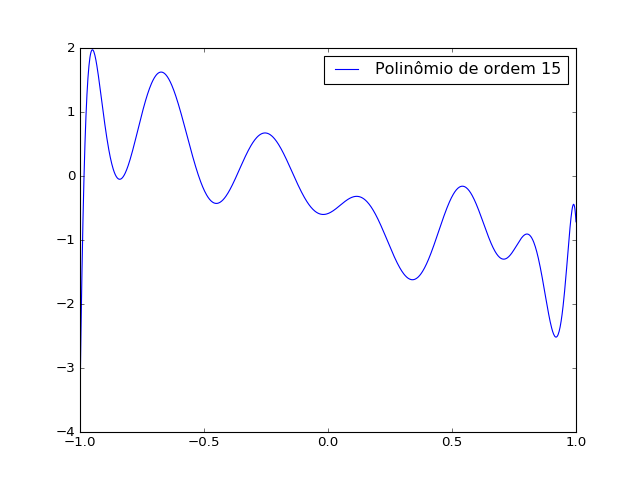

Analytic 0.353765
In Sample 0.364566
Out of Sample Experimental 0.364566
[(80, 15, 2, 0.35376455581988986)]
Q: 15
N: 80
error_diff: 1.6462354441801101


In [47]:
#%%time
# Just keep it running
while True:
    print("Running for %dth time" % idx)
    idx += 1
    result_time = []
    # Iterate complexity
    q = uniform(1, Q_MAX+1, EXPERIMENT).astype(int)
    print(q)
    # Iterate datapoints
    n = uniform(N_START, N_MAX+1, EXPERIMENT).astype(int)
    #Iterate experiments
    #async_result = lbview.map_async(
    #    create_plot,
    #    q,
    #    n,
    #    range(0,EXPERIMENT),
    #    uniform(0,(2**32)-1, EXPERIMENT).astype(int),
    #)
    #async_result.wait_interactive()
    #print("Speedup: %.2f x" % (1.0 * async_result.serial_time / async_result.wall_time))
    #result_time.append(async_result.wall_time)
    async_result = []
    seed_init = uniform(0,(2**32)-1, EXPERIMENT).astype(int)
    async_result.append(create_plot(15, 80, 1, seed_init[0]))
    print(async_result)
    for item in async_result:
        n = item[0]
        q = item[1]
        error_diff = item[2] - item[3]
        print("Q:", q)
        print("N:", n)
        print("error_diff:", error_diff)
        #plot_array[n-1,q-1] = (plot_array[n-1,q-1] * times_run[n-1,q-1] + error_diff)/(times_run[n-1,q-1]+1)
        #times_run[n-1,q-1] += 1
           
    #print("Round %d took %.2f seconds" % (idx, async_result.wall_time))
    #with open(NAME_PKL, 'wb') as pickle_file:
    #    pickle.dump(plot_array, pickle_file)
    #with open(NAME_RUN, 'wb') as pickle_file:
    #    pickle.dump(times_run, pickle_file)
    break

### PROBLEMAS 
## Problema 1: valor esperado dos polinômios de Legendre ao quadrado
Maneiras de resolver:
1. Função *expect* do SciPy: ordem de segundos
+ Avaliação da função em um número de amostras e a média: ordem de milisegundos mas certa imprecisão
+ Formação dos polinômios e integral em C: milisegundos mas a precisão explode a partir da ordem 43
+ Integral utilizando os coeficientes dos polinômios
+ Utilizar a integral de Legendre por partes

In [ ]:
%%timeit
f = create_legendre(50)
x_in = uniform(-1,1,30)
eout2 = get_eout(f, 2, x_in)
eout10 = get_eout(f, 10, x_in)

In [ ]:
# Create q+1 coefficients
coeffs = normal(size=100) 
# Create Qth order Legendre polynomial combination
leg_pol = Legendre(coeffs)

Método 1

In [ ]:
%%time
# Get expected value of Legendre polynomial in a uniform distribution varying from -1 to 1
exp_val = stats.uniform.expect(lambda x: (leg_pol ** 2)(x), loc=-1, scale=2)
print(exp_val)

Método 2

In [ ]:
%%timeit
# Get expected value of Legendre polynomial in a uniform distribution varying from -1 to 1
x = np.linspace(-1,1,10000)
exp_val = (leg_pol ** 2)(x).mean()
print(exp_val)

Método 3

In [ ]:
from scipy.integrate import quad

In [ ]:
from numba import cfunc, types, carray, autojit

@autojit
def integrand(x, coefs):
    polyn = 0
    for idx,coef in enumerate(coefs):
        polyn += coef*x**idx
    L = (polyn ** 2)
    return L
    
def normal_integrand(x, coefs):
    polyn = 0
    for idx,coef in enumerate(coefs):
        polyn += (coef*(x ** idx))
    L = (polyn ** 2)
    return L

In [ ]:
num=np.linspace(-1,1,num=30)               #setting up array of values for t

In [ ]:
%%timeit
Lv = 0
last, lastG = 0.0, -1.0
p = leg_pol.convert(kind=poly.Polynomial)
coefs=p.coef

for g in num:
    #L = lambda x: (leg_pol ** 2)(x) * 0.5
    Lval,x = quad(integrand, lastG, g, args=(coefs,))
    #Lval,x = quad(normal_integrand, lastG, g, args=(coefs,))
    last, lastG = last + Lval, g
Lv = last * 0.5
print(Lv)

Método 4

In [ ]:
%%time
polyn = leg_pol.convert(kind=poly.Polynomial)
coefs=polyn.coef
energy = 0

for i in range(0,len(coefs)):
    j_start = i % 2
    for j in range(j_start,len(coefs), 2):
        energy += Decimal(coefs[i])*Decimal(coefs[j])/Decimal(i+j+1)
        idx+=1

print(energy)
print(type(energy))

In [ ]:
getcontext().prec=600

Método 5

In [ ]:
%%timeit
exp_val = 0
for i in range(0,len(coeffs),2):
    coeff_temp = [0]*len(coeffs)
    coeff_temp[i] = coeffs[i]
    try:
        coeff_temp[i+1] = coeffs[i+1]
    except IndexError:
        pass
    # Create Qth order Legendre polynomial combination
    leg_pol_temp = Legendre(coeff_temp)
    leg_integ = leg_pol_temp.integ()
    coeffs_sum = np.insert(coeff_temp, 0, 0)
    exp_val += np.multiply(coeffs_sum, leg_integ.coef).sum()
print(exp_val)

In [ ]:
plot_array = np.zeros((N_MAX-N_START+1,Q_MAX))
times_run = np.zeros((N_MAX-N_START+1,Q_MAX))
for item in item_array:
    n = item[0]
    q = item[1]
    print("Item [%d,%d]" % (n,q))
    error_diff = item[2] - item[3]
    print(error_diff)
    plot_array[n-1,q-1] = (plot_array[n-1,q-1] * times_run[n-1,q-1] + error_diff)/(times_run[n-1,q-1]+1)
    times_run[n-1,q-1] += 1
print("Plot Array")
print(plot_array)
print("Times run")
print(times_run)